In [28]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
def f(x):
    return 3*x**2 - 4*x+5

In [30]:
f(3)

20

In [31]:
xs = np.arange(-5,5 , 0.25)
ys = f(xs)

In [32]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

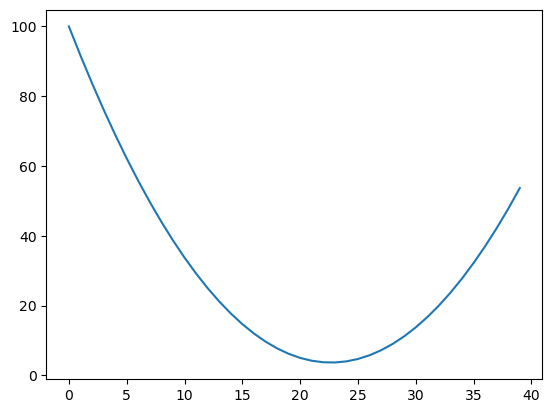

In [33]:
plt.plot(ys)

In [34]:
h = 0.000001
x = 2/3
(f(x+h) - f(x))/h

2.999378523327323e-06

In [35]:
# let get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [36]:
h = 0.0001
#input 
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c+=h
d2= a*b+c
print('d1' , d1)
print('d2' , d2)
print("Slope" , (d2-d1)/h)

d1 4.0
d2 4.0001
Slope 0.9999999999976694


In [37]:
class Value:
    def __init__(self, data , _children=(), _op='' , label=''):
        self.data = data;
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda : None
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other , Value) else Value(other)
        out = Value(self.data + other.data , (self , other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other , Value) else Value(other)
        out = Value(self.data * other.data , (self , other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            print(other.data)
            other.grad += self.data * out.grad
        out._backward = _backward   
        return out
    
    def __rmul__(self, other): # other * self
        return self*other
    
    def __truediv__(self, other): #self/other
        return self * other.data**-1
    
    def __pow__(self , other):
        assert isinstance(other.data,(int, float)),"only supporting int/float power for now"
        out = Value(self.data ** other.data , (self,) , f'**{other.data}')
                    
        def _backward():
            self.grad += other.data*(self.data)**(other.data-1)* out.grad
        out._backward = _backward   
        return out
                    
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward   
        return out
    
    
    def tanh(self):
        x = self.data;
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        print(t)
        out = Value(t , (self, ), "tanh")
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward   

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            
        build_topo(self)
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
    

In [38]:
a = Value(2.0)
b = Value(4.0)
b**a

Value(data = 16.0)

In [39]:
from graphviz import Digraph

def trace(root):
    #build a set of all nodes and edges in a  graph
    nodes, edges =  set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build (root)
    return nodes , edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular ("record") node for it
        dot.node(name = uid , label = "{%s | data %.4f ||  grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
                 
    for n1 , n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot         

In [13]:
# dd/dc = 1.0
# d = c+e
# (f(x+h) - f(x))/h
# ((c+h +e) - (c+e))/h
# (c+h+e-c-e)/h
# h/h = 1.0

# dd/de = 1.0
# d = c+e

# want :
# dL/dc = (dL/dd)*(dd/dc)

# KNOW:
# dL/dd
# dd/dc

#dL/de = -2.0
#dl/da = (dL/de)*(de/da)

In [14]:
def lol():
    h=0.001
    a = Value(2.0 , label="a")
    a.exp()
    b = Value(-3.0 , label="b")
    c = Value(10.0 , label="c")
    print(a)
    e=a*b; e.label="e"
    d = e+c; d.label="d"
    f = Value(-2.0 , label='f')
    L = d*f
    L1=L.data
    
    a = Value(2.0 , label="a")
    b = Value(-3.0 , label="b")
    c = Value(10.0 , label="c")
    e=a*b; e.label="e"
    d = e+c; d.label="d"
    f = Value(-2.0 , label='f')
    L = d*f ; L.label='L'
    L2=L.data
    
    print((L2-L1)/h)
lol()    
    

Value(data = 2.0)
0.0


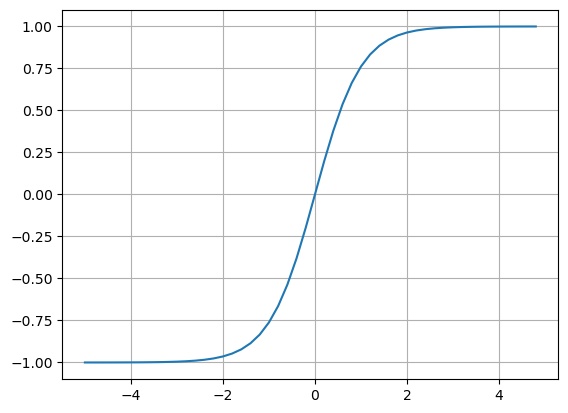

In [15]:
plt.plot(np.arange(-5,5,0.2) , np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [16]:
# Input x1 x2
x1 = Value(2.0 , label="x1")
x2 = Value(0.0 , label="x2")

# Weight w1 , w2
w1 = Value(-3.0 , label="w1")
w2 = Value(1.0 , label='w2')

# Bias b
b = Value(6.8813735870195431 , label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2w2'

n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'


0.7071067811865476


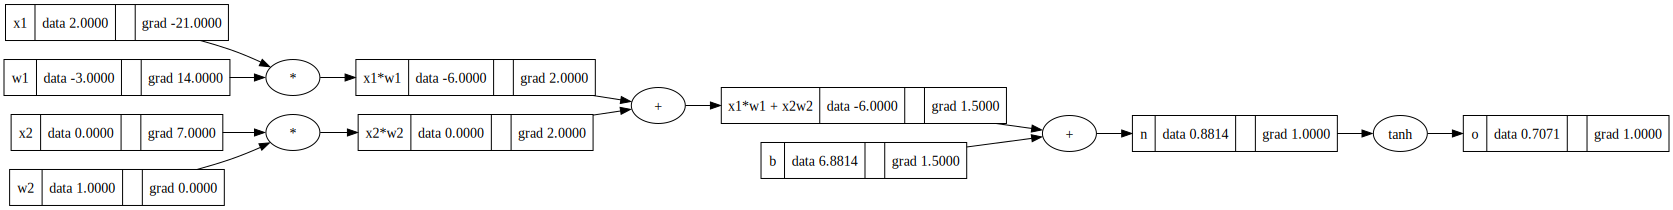

In [42]:
draw_dot(o)

In [41]:
o.backward()

-3.0
1.0


In [19]:
o.grad=1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

1.0
-3.0


In [20]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x2._backward()


-3.0
1.0


In [21]:
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

n.grad = 0.5
o.grad = 1.0

x1w1.grad = 0.5
x2w2.grad = 0.5

x1w1x2w2.grad = 0.5
b.grad = 0.5

In [22]:
1 - o.data**2

0.4999999999999999

In [23]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 -  o**2


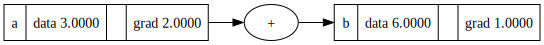

In [24]:
a= Value(3.0, label='a')
b =  a+a;  b.label="b"
b.backward()
draw_dot(b)

In [25]:
a = Value(-2.0, label='a')
b = Value(3.0 ,  label='b')
d=  a*b;  d.label='d'
e = a+b;  e.label='e'
f  =d*e;  f.label='f'

1.0
3.0


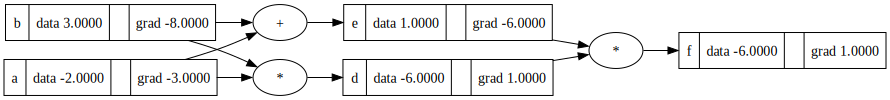

In [26]:
f.backward()
draw_dot(f)